In [15]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from math import sqrt
from scipy.ndimage import label

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import warnings
warnings.filterwarnings("ignore")

PyTorch version: 2.5.1
Torchvision version: 0.20.1+cpu
CUDA is available: True


In [2]:
image = cv2.imread('data/pot2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

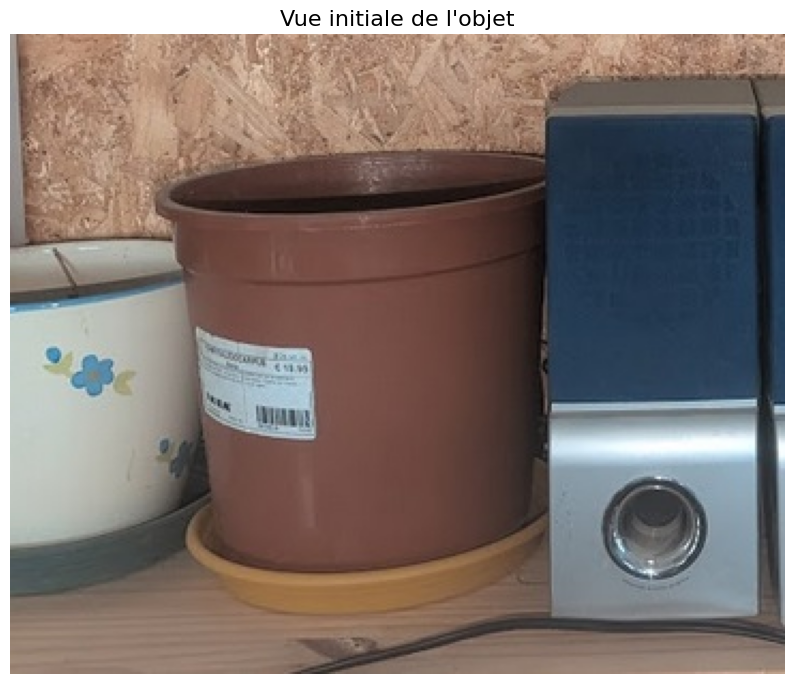

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title("Vue initiale de l'objet", fontsize=16)
plt.axis('off')
plt.show()

## chargement du modèle

In [16]:
sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"
#device = "cuda"
device='cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device);

In [5]:
mask_generator = SamAutomaticMaskGenerator(sam)

# génère les masks de segmentation
masks = mask_generator.generate(image)  # très lent a cause du cpu à la place du gpu

## visualisation des 3 premiers mask

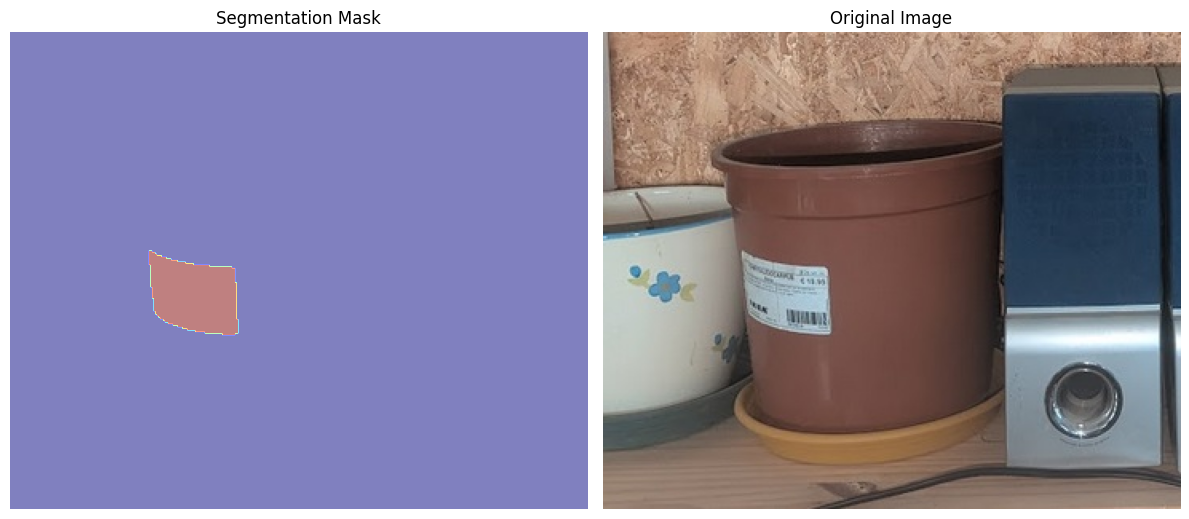

0.9843119382858276


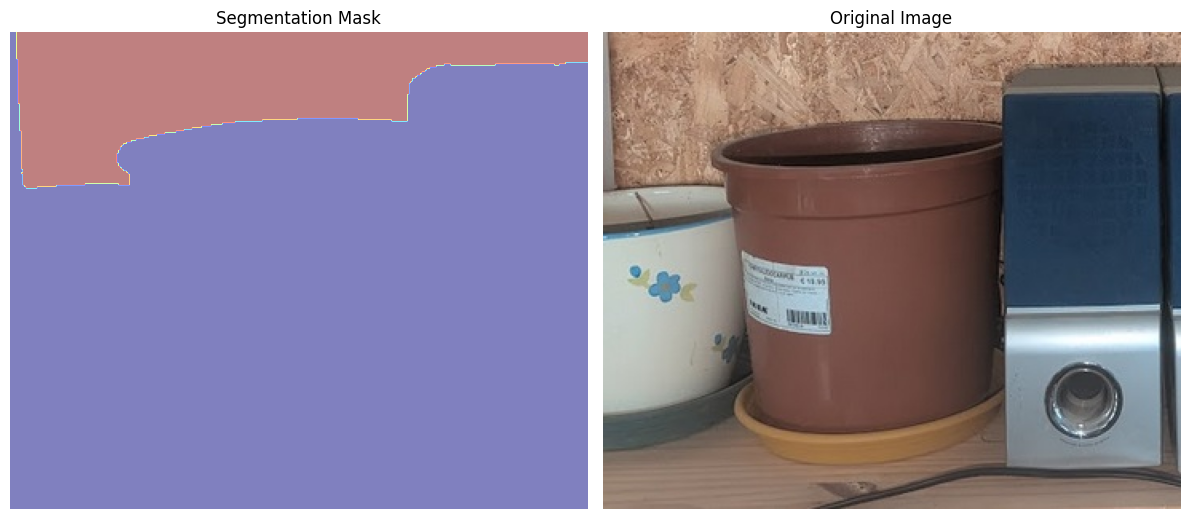

0.9880371689796448


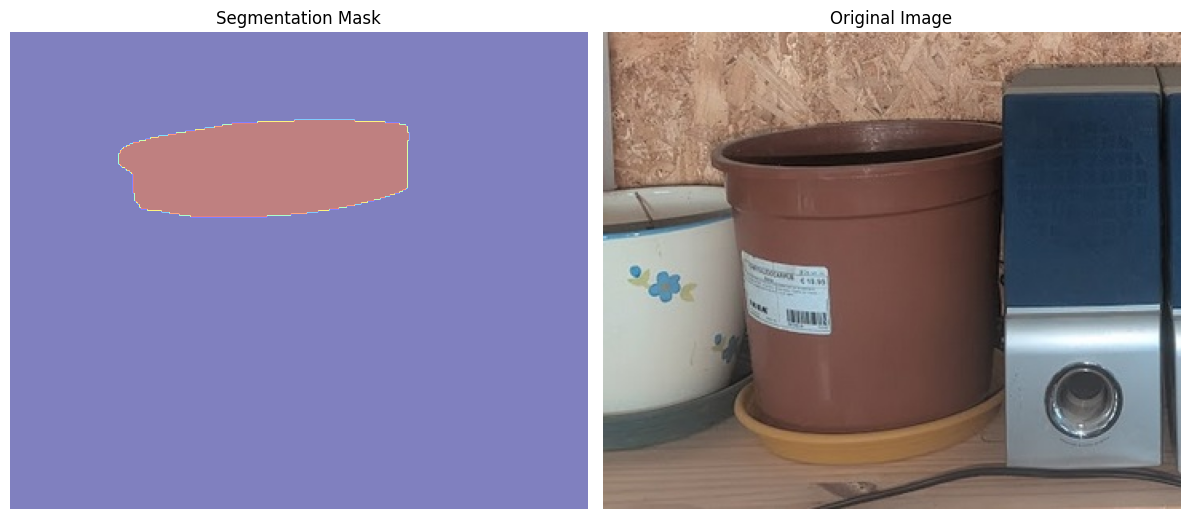

0.989513099193573


In [6]:
i = 0
for mask in masks:
    segmentation_mask = mask['segmentation']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(segmentation_mask, cmap='jet', alpha=0.5)
    axes[0].axis('off')
    axes[0].set_title("Segmentation Mask")
    
    axes[1].imshow(image)
    axes[1].axis('off')
    axes[1].set_title("Original Image")
    
    plt.tight_layout()
    plt.show()
    
    print(mask['stability_score'])
    
    i += 1
    if i >= 3:
        break


## visualisation des premiers mask + rectangles délimitant les objets

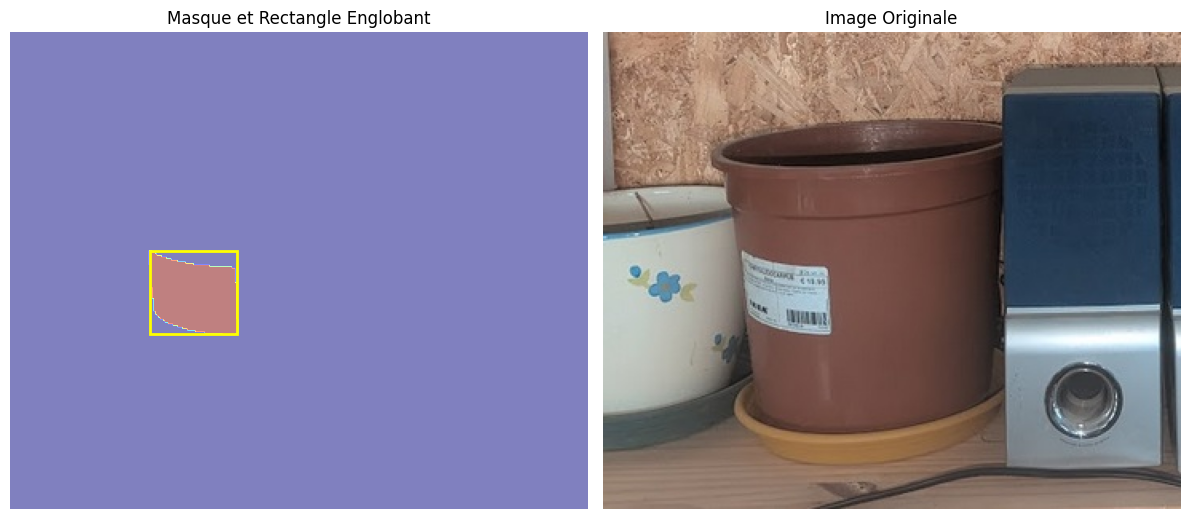

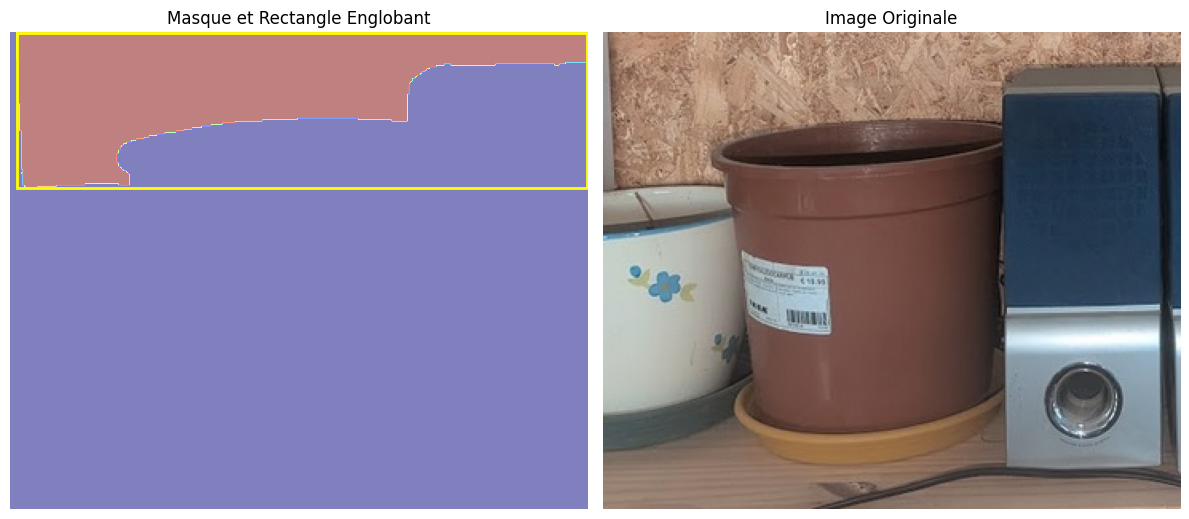

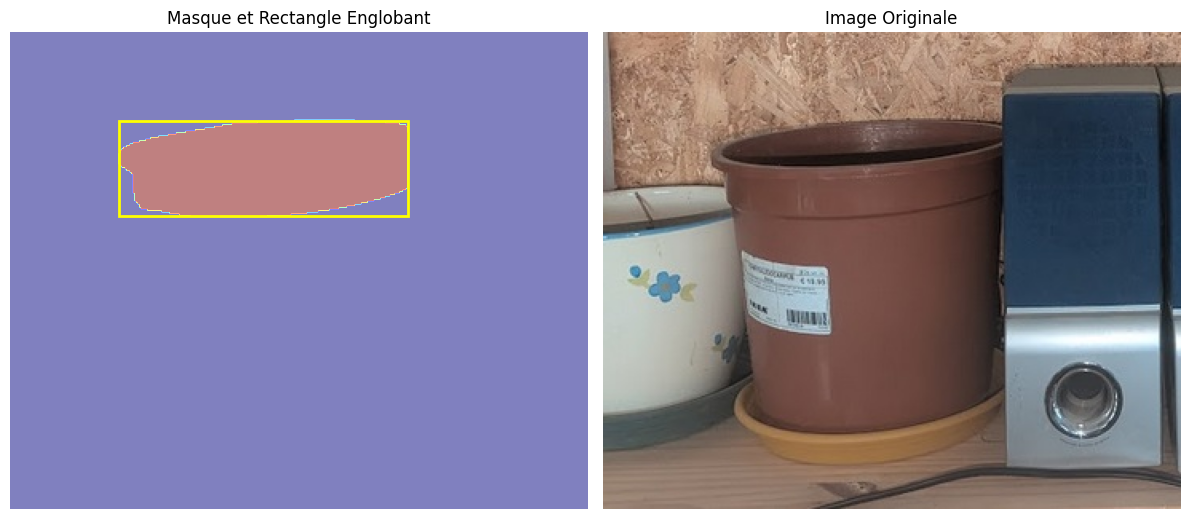

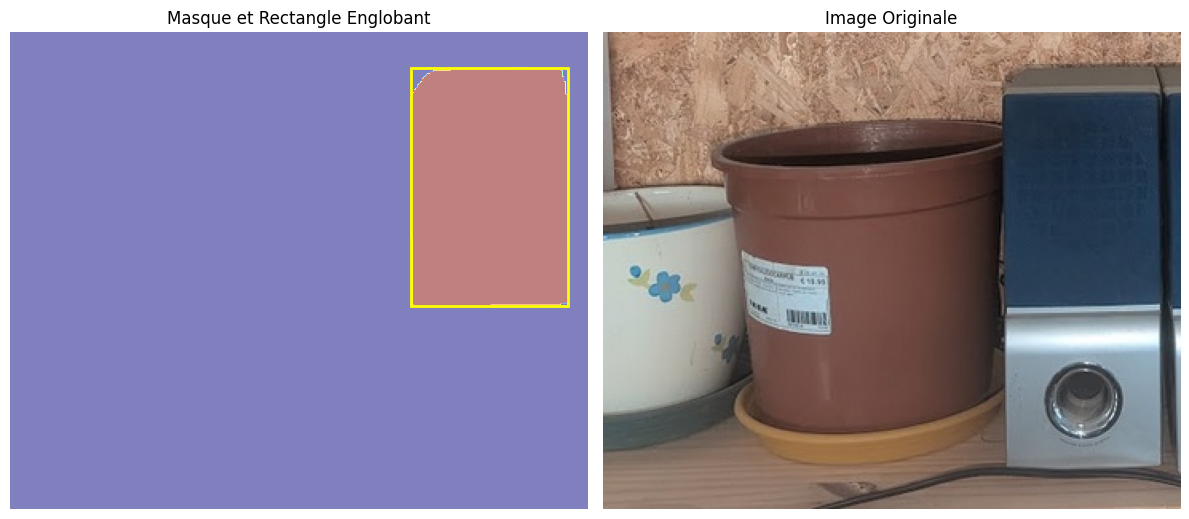

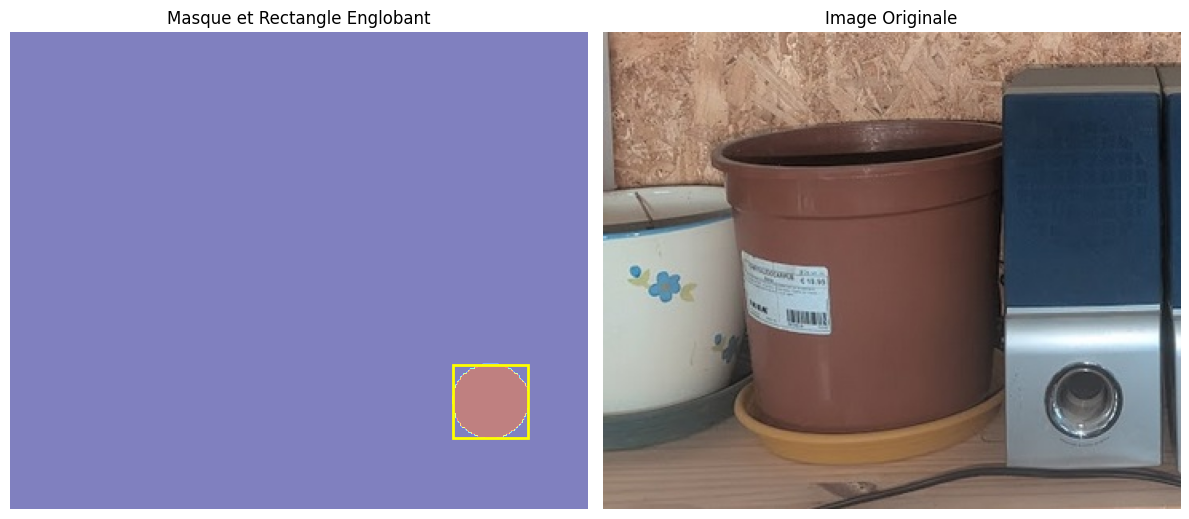

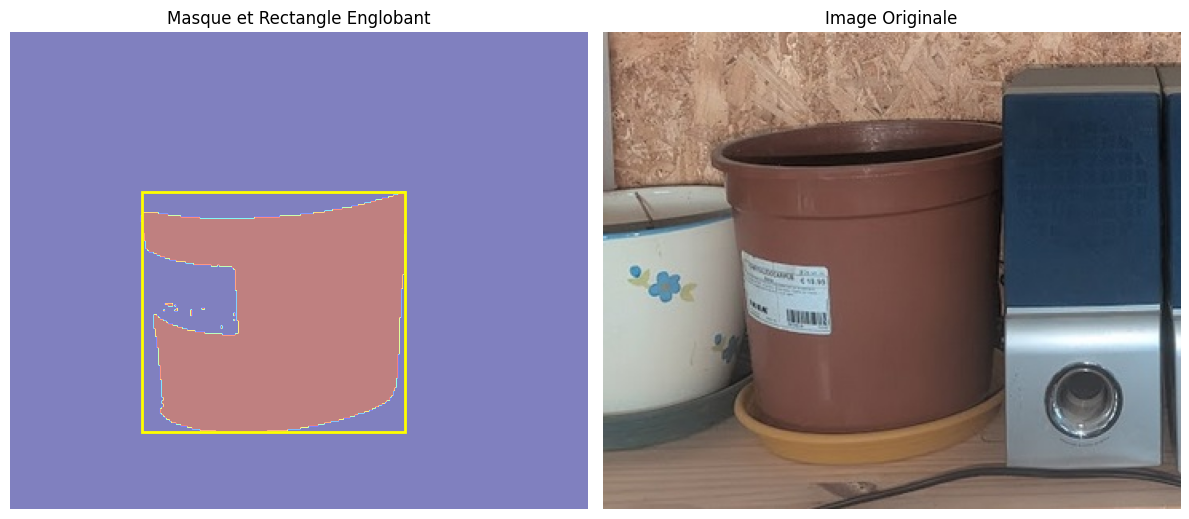

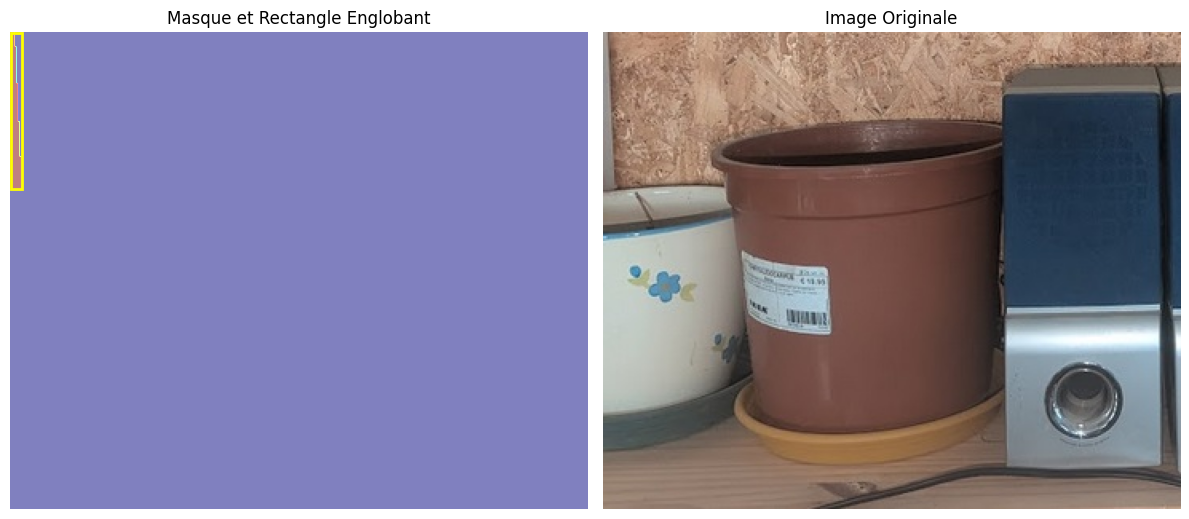

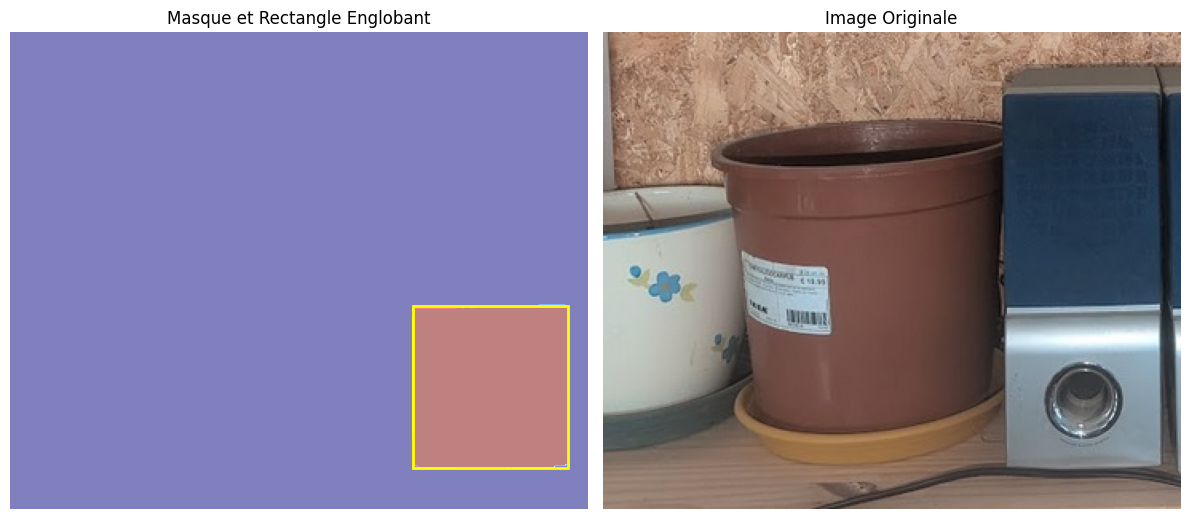

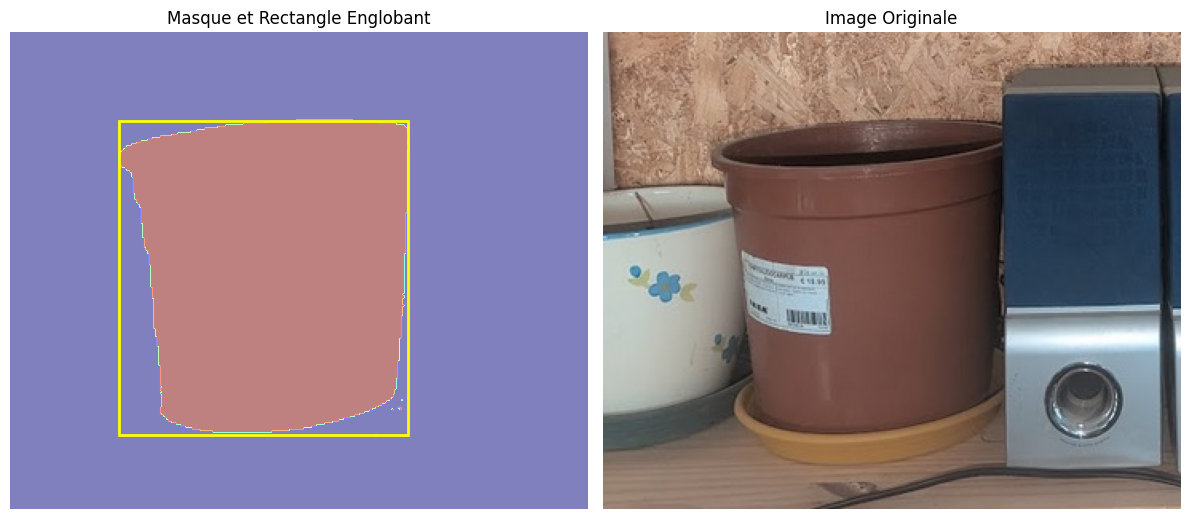

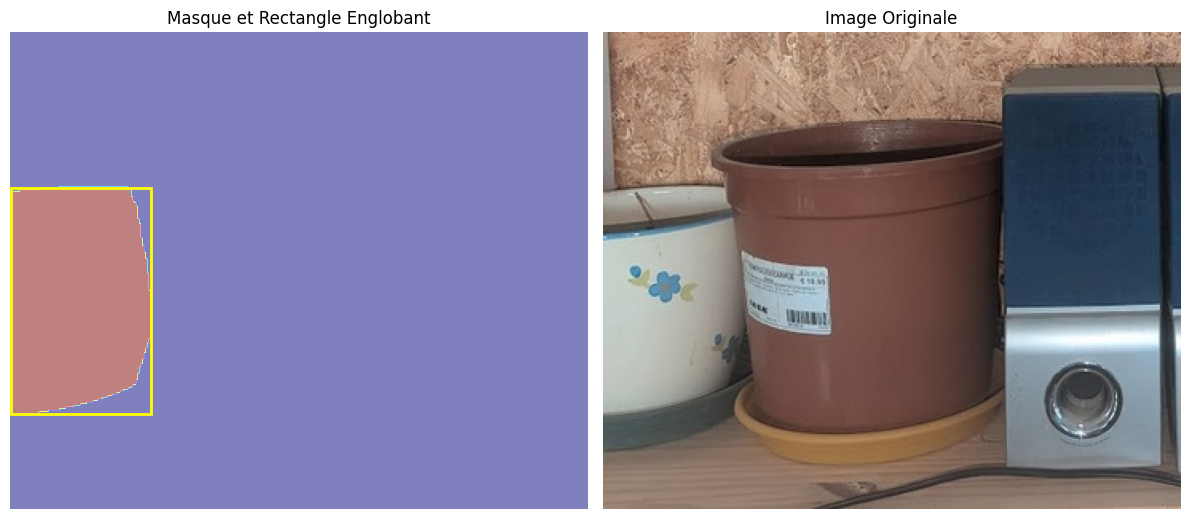

In [7]:
i = 0
for mask in masks:
    segmentation_mask = mask['segmentation']
    bbox = mask['bbox']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(segmentation_mask, cmap='jet', alpha=0.5)
    axes[0].add_patch(plt.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        edgecolor='yellow', facecolor='none', linewidth=2
    ))
    axes[0].axis('off')
    axes[0].set_title("Masque et Rectangle Englobant")
    
    axes[1].imshow(image)
    axes[1].axis('off')
    axes[1].set_title("Image Originale")
    
    plt.tight_layout()
    plt.show()
    
    i += 1
    if i >= 10:
        break


## calcul de l'écart au centre de chaque objet

In [8]:
def compute_center_of_object(segmentation):
    # récup le centre de l'objet
    true_indices = np.where(segmentation)
    

    center_x = np.mean(true_indices[1])
    center_y = np.mean(true_indices[0])
    
    return (center_x, center_y)

for mask in masks:
    segmentation_mask = mask['segmentation']
    

    center = compute_center_of_object(segmentation_mask)
    mask['center'] = center  # ajoute le centre de chaque mask

In [9]:
def dist(mask_center,center_image):
    score=1+(mask_center[0]-center_image[0])**2+(mask_center[1]-center_image[1])**2
    return score
    
for mask in masks:
    center_image=[(mask['crop_box'][2]-mask['crop_box'][0])/2,(mask['crop_box'][3]-mask['crop_box'][1])/2]
    mask['distance_center']=dist(mask['center'],center_image)
    mask['score_keep']=mask['area']*mask['predicted_iou']/dist(mask['center'],center_image)

In [10]:
def is_disjointed(segmentation,tolerance=0.99):
    # label les pixels de chaque section du mask de la segmentation
    # false -> non disjoint, true -> disjoint
    labeled_mask, num_components = label(segmentation)
    
    # si un seul label; connecté
    if num_components == 1:
        return False
    

    component_sizes = [np.sum(labeled_mask == i) for i in range(1, num_components + 1)]
    total_area = np.sum(segmentation)
    
    
    largest_component_size = max(component_sizes)
    
    # Si le plus gros morceau contient > tolerance des pixels, on considère que c'est pas disjoint
    if largest_component_size / total_area >= tolerance:
        return False
    else:
        return True


def rate_masks(masks, tolerance=0.99):
    for mask in masks:
        segmentation_mask = mask['segmentation']
        
        center = compute_center_of_object(segmentation_mask)
        mask['center'] = center
        
        mask['keep'] = not is_disjointed(segmentation_mask, tolerance)  # If disjointed, set 'keep' to False, else True
        
        #print(f"Object center: {center}, Keep: {mask['keep']}")
    
    return masks


masks = rate_masks(masks)

In [11]:
def find_best_mask_with_index(masks):

    best_mask = None
    best_index = -1
    highest_score = -1  
    
    for i, mask in enumerate(masks):
        if mask['keep']: 
            score = mask.get('score_keep', 0)
            if score > highest_score:
                highest_score = score
                best_mask = mask
                best_index = i
    
    return best_mask, best_index

best_mask, best_index = find_best_mask_with_index(masks)

In [12]:
masks[best_index]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 30039,
 'bbox': [68, 55, 181, 197],
 'predicted_iou': 1.000638484954834,
 'point_coords': [[243.21875, 191.546875]],
 'stability_score': 0.9708829522132874,
 'crop_box': [0, 0, 362, 299],
 'center': (165.4632311328606, 148.4803755118346),
 'distance_center': 243.43082092777823,
 'score_keep': 123.47729566452888,
 'keep': True}

## extraction de l'objet recherché

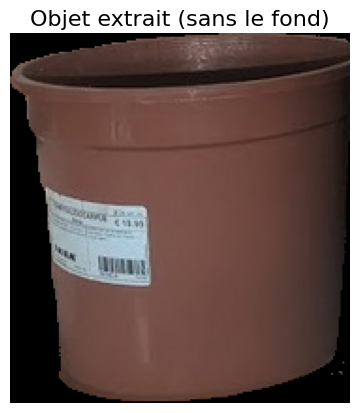

In [13]:
best_mask = masks[best_index]

# extraire la segmentation et la délémitation par le rectangle
segmentation = best_mask['segmentation']
bbox = best_mask['bbox']

x, y, width, height = bbox
x2, y2 = x + width, y + height


cropped_image = image[y:y2, x:x2]
segmentation_cropped = segmentation[y:y2, x:x2]

extracted_image = np.zeros_like(cropped_image)
extracted_image[segmentation_cropped] = cropped_image[segmentation_cropped]

# Display the extracted image
plt.imshow(extracted_image)
plt.title("Objet extrait (sans le fond)", fontsize=16)
plt.axis('off')
plt.show()

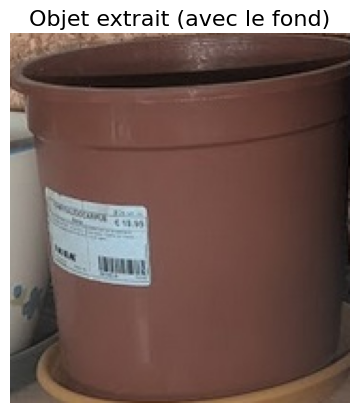

In [14]:
# extraire les coins du rectangle
x, y, width, height = bbox
x2, y2 = x + width, y + height

# crop la zone de l'image délimité par le rectangle
bounding_box_image = image[y:y2, x:x2]

plt.imshow(bounding_box_image)
plt.title("Objet extrait (avec le fond)", fontsize=16)
plt.axis('off')
plt.show()